# Image level consistency check

In [1]:
import numpy as np
import pandas as pd
import os
import os.path

import matplotlib.pyplot as plt
import plotly.express as px

from core import *
from config import image_stats_file, xls_file, figures_dir, latex_dir, image_level_results_file, image_level_threshold

pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.width', 10000)

In [2]:
# reading image statistics
data= pd.read_csv(image_stats_file)

# reading the summary page
methods= pd.read_excel(xls_file, engine='openpyxl')
#methods= methods.iloc[:methods[methods['key'].isnull()].index[0]]
methods= methods[methods['flag'] == 'primary']
methods.index= methods['key']

# reading the image level figures
xl= pd.ExcelFile(xls_file, engine='openpyxl')
image_level= {}
for s in xl.sheet_names[1:]:
    image_level[s]= xl.parse(s)

print('image level figures available for: %s' % str(list(image_level.keys())))

image level figures available for: ['mo2017', 'meng2015', 'hassan2018', 'tang2017', 'zhu2016', 'geetharamani2016', 'wang2015', 'singh2016', 'singh2017', 'saroj2020', 'dash2018', 'fathi2013', 'imani2015', 'emary2014', 'waheed2015', 'rahebi2014', 'thangaraj2017', 'adapa2020', 'escorcia-gutierrez2020', 'li2016', 'khan2016', 'fraz2012b', 'fraz2012', 'lupascu2010', 'marin2011', 'ricci2007', 'barkana2017', 'tamim2020', 'frucci2016', 'dash2020', 'moghimirad2012', 'odstrcilik2013', 'biswal2017', 'bharkad2017', 'lupascu2016', 'kumar2020', 'narkthewan2019']


In [3]:
methods.columns

Index(['key', 'flag', 'year', 'all_previous_processed', 'acc', 'sens', 'spec', 'digits', 'highest_ranked', 'second_human_observer', 'second_human_acc', 'second_human_sens', 'second_human_spec', 'image_level', 'short_description', 'operating_principles', 'citations', 'explicit_fov_usage', 'invalid_ranking', 'cause_of_invalid_ranking'], dtype='object')

In [4]:
methods.index

Index(['adapa2020', 'alom2019', 'anzalone2008', 'azzopardi2014', 'barkana2017', 'brancati2018', 'budai2013', 'chalakkal2017', 'cheng2014', 'dai2015', 'dasgupta2017', 'dash2018', 'dizdaroglu2012', 'emary2014', 'escorcia-gutierrez2020', 'fan2017', 'fathi2013', 'fraz2012', 'fraz2012b', 'frucci2016', 'frucci2017', 'geetharamani2016', 'hassan2018', 'hu2018', 'imani2015', 'javidi2017', 'jebaseeli2019', 'jiang2019', 'kaur2017', 'khan2016', 'kovacs2016', 'kumar2016', 'li2016', 'liskowski2016', 'lupascu2010', 'mapayi2015', 'marin2011', 'melinscak2015', 'memari2017', 'mendonca2006', 'meng2015', 'miri2011', 'mo2017', 'moghimirad2012', 'nazari2013', 'ngo2017', 'noh2019', 'odstrcilik2013', 'palanivel2020', 'pan2019', 'panda2016', 'pandey2016', 'park2020', 'rahebi2014', 'rezaee2017', 'ricci2007', 'roychowdhury2015', 'salazar-gonzalez2014', 'saleh2011', 'samuel2019', 'saroj2020', 'shah2017', 'shukla2020', 'singh2016', 'singh2017', 'song2017', 'soomro2017', 'soomro2018', 'soomro2019', 'sreejini2015', 

In [5]:
# test images with annotations #1 as ground truth
data_test= data[(data['test'] == True) & (data['annotator'] == 1)].reset_index()

# test images with annotations #2 as ground truth
data_test_obs2= data[(data['test'] == True) & (data['annotator'] == 2)].reset_index()

In [6]:
# extracting figures with and without FoV
data_test_with_fov= data_test[data_test['fov'] == True].reset_index(drop=True)
data_test_without_fov= data_test[data_test['fov'] == False].reset_index(drop=True)

data_test_with_fov_obs2= data_test_obs2[data_test_obs2['fov'] == True].reset_index(drop=True)
data_test_without_fov_obs2= data_test_obs2[data_test_obs2['fov'] == False].reset_index(drop=True)

In [7]:
data_test_with_fov

,index,id,n_all,p,n,fov,annotator,tp,fp,tn,...,ground_truth,width,height,img_size,test,acc,sens,spec,dice,dice_no_fp
0,40,7,227675,30144,197531,True,1,20664.0,2966.0,194565.0,...,1.0,584,565,329960,True,0.945334,0.685510,0.984985,0.768550,0.813415
1,44,2,225087,33723,191364,True,1,27780.0,5455.0,185909.0,...,1.0,584,565,329960,True,0.949362,0.823770,0.971494,0.829774,0.903371
2,48,19,227388,27367,200021,True,1,24806.0,7938.0,192083.0,...,1.0,584,565,329960,True,0.953828,0.906420,0.960314,0.825340,0.950913
3,52,10,227332,27152,200180,True,1,19469.0,4202.0,195978.0,...,1.0,584,565,329960,True,0.947720,0.717037,0.979009,0.766149,0.835203
4,56,12,227605,28490,199115,True,1,21958.0,4543.0,194572.0,...,1.0,584,565,329960,True,0.951341,0.770727,0.977184,0.798603,0.870520
5,60,9,227660,26740,200920,True,1,20556.0,6098.0,194822.0,...,1.0,584,565,329960,True,0.946051,0.768736,0.969650,0.769974,0.869249
6,64,14,225854,26631,199223,True,1,20540.0,4106.0,195117.0,...,1.0,584,565,329960,True,0.954851,0.771282,0.979390,0.801139,0.870874
7,68,4,227577,30343,197234,True,1,23769.0,5138.0,192096.0,...,1.0,584,565,329960,True,0.948536,0.783344,0.973950,0.802329,0.878511
8,72,6,227499,32105,195394,True,1,24194.0,6540.0,188854.0,...,1.0,584,565,329960,True,0.936479,0.753590,0.966529,0.770031,0.859482
9,76,16,227694,29791,197903,True,1,23202.0,4884.0,193019.0,...,1.0,584,565,329960,True,0.949612,0.778826,0.975321,0.801769,0.875663


## Calculating the scores for all image level figures

In [8]:
# checking the consistencies at the image level

for s in image_level:
    if not s in methods.index:
        continue

    print('processing', s)

    for i, row in image_level[s].iterrows():
        image_id= row['image']

        p_with_fov= data_test_with_fov[data_test_with_fov['id'] == image_id]['p'].values[0]
        n_with_fov= data_test_with_fov[data_test_with_fov['id'] == image_id]['n'].values[0]
        p_without_fov= data_test_without_fov[data_test_without_fov['id'] == image_id]['p'].values[0]
        n_without_fov= data_test_without_fov[data_test_without_fov['id'] == image_id]['n'].values[0]

        p_with_fov_obs2= data_test_with_fov[data_test_with_fov_obs2['id'] == image_id]['p'].values[0]
        n_with_fov_obs2= data_test_with_fov[data_test_with_fov_obs2['id'] == image_id]['n'].values[0]
        p_without_fov_obs2= data_test_without_fov[data_test_without_fov_obs2['id'] == image_id]['p'].values[0]
        n_without_fov_obs2= data_test_without_fov[data_test_without_fov_obs2['id'] == image_id]['n'].values[0]

        digits= methods.loc[s]['digits']
        if digits > 2:
            eps= 10.0**(-digits)
        else:
            eps= 10.0**(-digits)/2

        image_level[s].loc[i, 'n_with_fov']= n_with_fov
        image_level[s].loc[i, 'n_without_fov']= n_without_fov
        image_level[s].loc[i, 'n_with_fov_obs2']= n_with_fov_obs2
        image_level[s].loc[i, 'n_without_fov_obs2']= n_without_fov_obs2
        image_level[s].loc[i, 'p_with_fov']= p_with_fov
        image_level[s].loc[i, 'p_without_fov']= p_without_fov
        image_level[s].loc[i, 'p_with_fov_obs2']= p_with_fov_obs2
        image_level[s].loc[i, 'p_without_fov_obs2']= p_without_fov_obs2

        image_level[s].loc[i, 'consistency_with_fov']= consistency_image_level(p_with_fov, n_with_fov, row['acc'], row['sens'], row['spec'], eps)
        image_level[s].loc[i, 'consistency_without_fov']= consistency_image_level(p_without_fov, n_without_fov, row['acc'], row['sens'], row['spec'], eps)

        image_level[s].loc[i, 'consistency_with_fov_obs2']= consistency_image_level(p_with_fov_obs2, n_with_fov_obs2, row['acc'], row['sens'], row['spec'], eps)
        image_level[s].loc[i, 'consistency_without_fov_obs2']= consistency_image_level(p_without_fov_obs2, n_without_fov_obs2, row['acc'], row['sens'], row['spec'], eps)

processing mo2017
processing meng2015
processing hassan2018
processing tang2017
processing zhu2016
processing geetharamani2016
processing wang2015
processing singh2016
processing singh2017
processing saroj2020
processing dash2018
processing fathi2013
processing imani2015
processing emary2014
processing waheed2015
processing rahebi2014
processing thangaraj2017
processing adapa2020
processing escorcia-gutierrez2020
processing li2016
processing khan2016
processing fraz2012b
processing fraz2012
processing lupascu2010
processing marin2011
processing ricci2007
processing barkana2017
processing tamim2020
processing frucci2016
processing dash2020
processing moghimirad2012
processing odstrcilik2013
processing bharkad2017
processing lupascu2016
processing kumar2020
processing narkthewan2019


In [9]:
# calculating the percentages of images with a given number of negatives falling in the calculated range
for key in image_level:
    if not key in methods.index:
        continue
    methods.loc[key, 'image_level_consistency_with_fov']= np.sum(image_level[key]['consistency_with_fov']*1)/len(image_level[key])
    methods.loc[key, 'image_level_consistency_without_fov']= np.sum(image_level[key]['consistency_without_fov']*1)/len(image_level[key])
    methods.loc[key, 'n_image_level']= len(image_level[key])

## Printing the results of all image level figures


In [10]:
image_level['mo2017']

,image,acc,sens,spec,n_with_fov,n_without_fov,n_with_fov_obs2,n_without_fov_obs2,p_with_fov,p_without_fov,p_with_fov_obs2,p_without_fov_obs2,consistency_with_fov,consistency_without_fov,consistency_with_fov_obs2,consistency_without_fov_obs2
0,3,0.9323,0.5677,0.9944,192841.0,297067.0,192841.0,297067.0,32886.0,32893.0,32886.0,32893.0,True,False,True,False
1,19,0.9586,0.9094,0.9653,200021.0,302589.0,200021.0,302589.0,27367.0,27371.0,27367.0,27371.0,True,False,True,False


In [11]:
image_level['meng2015']

,image,acc,sens,spec,n_with_fov,n_without_fov,n_with_fov_obs2,n_without_fov_obs2,p_with_fov,p_without_fov,p_with_fov_obs2,p_without_fov_obs2,consistency_with_fov,consistency_without_fov,consistency_with_fov_obs2,consistency_without_fov_obs2
0,1,0.9534,0.7928,0.9770,194965.0,300520.0,194965.0,300520.0,29412.0,29440.0,29412.0,29440.0,False,False,False,False
1,2,0.9561,0.7646,0.9893,191364.0,296170.0,191364.0,296170.0,33723.0,33790.0,33723.0,33790.0,False,False,False,False
2,3,0.9478,0.6927,0.9859,192841.0,297067.0,192841.0,297067.0,32886.0,32893.0,32886.0,32893.0,False,False,False,False
3,4,0.9555,0.7661,0.9830,197234.0,299606.0,197234.0,299606.0,30343.0,30354.0,30343.0,30354.0,False,False,False,False
4,5,0.9605,0.7739,0.9854,196795.0,299048.0,196795.0,299048.0,30898.0,30912.0,30898.0,30912.0,False,False,False,False
5,6,0.9459,0.6939,0.9853,195394.0,297844.0,195394.0,297844.0,32105.0,32116.0,32105.0,32116.0,False,False,False,False
6,7,0.9578,0.7972,0.9764,197531.0,299808.0,197531.0,299808.0,30144.0,30152.0,30144.0,30152.0,False,False,False,False
7,8,0.9493,0.7285,0.9732,196937.0,301571.0,196937.0,301571.0,28311.0,28389.0,28311.0,28389.0,False,False,False,False
8,9,0.9505,0.7343,0.9791,200920.0,303219.0,200920.0,303219.0,26740.0,26741.0,26740.0,26741.0,True,False,True,False
9,10,0.9606,0.7737,0.9823,200180.0,302804.0,200180.0,302804.0,27152.0,27156.0,27152.0,27156.0,False,False,False,False


In [12]:
image_level['hassan2018']

,image,acc,sens,spec,n_with_fov,n_without_fov,n_with_fov_obs2,n_without_fov_obs2,p_with_fov,p_without_fov,p_with_fov_obs2,p_without_fov_obs2,consistency_with_fov,consistency_without_fov,consistency_with_fov_obs2,consistency_without_fov_obs2
0,1,0.97082,0.88308,0.98550,194965.0,300520.0,194965.0,300520.0,29412.0,29440.0,29412.0,29440.0,False,False,False,False
1,2,0.96653,0.88511,0.98724,191364.0,296170.0,191364.0,296170.0,33723.0,33790.0,33723.0,33790.0,False,False,False,False
2,3,0.98801,0.79658,0.98911,192841.0,297067.0,192841.0,297067.0,32886.0,32893.0,32886.0,32893.0,False,False,False,False
3,4,0.97560,0.88457,0.96894,197234.0,299606.0,197234.0,299606.0,30343.0,30354.0,30343.0,30354.0,False,False,False,False
4,5,0.96314,0.87792,0.96619,196795.0,299048.0,196795.0,299048.0,30898.0,30912.0,30898.0,30912.0,False,False,False,False
5,6,0.96970,0.78907,0.97798,195394.0,297844.0,195394.0,297844.0,32105.0,32116.0,32105.0,32116.0,False,False,False,False
6,7,0.97012,0.88990,0.97824,197531.0,299808.0,197531.0,299808.0,30144.0,30152.0,30144.0,30152.0,False,True,False,True
7,8,0.95812,0.85616,0.96890,196937.0,301571.0,196937.0,301571.0,28311.0,28389.0,28311.0,28389.0,False,False,False,False
8,9,0.97733,0.86512,0.98531,200920.0,303219.0,200920.0,303219.0,26740.0,26741.0,26740.0,26741.0,False,False,False,False
9,10,0.95667,0.78872,0.97847,200180.0,302804.0,200180.0,302804.0,27152.0,27156.0,27152.0,27156.0,False,False,False,False


In [13]:
image_level['tang2017']

,image,acc,sens,spec,n_with_fov,n_without_fov,n_with_fov_obs2,n_without_fov_obs2,p_with_fov,p_without_fov,p_with_fov_obs2,p_without_fov_obs2,consistency_with_fov,consistency_without_fov,consistency_with_fov_obs2,consistency_without_fov_obs2
0,1,0.9650,0.8074,0.9800,194965.0,300520.0,194965.0,300520.0,29412.0,29440.0,29412.0,29440.0,False,False,False,False
1,2,0.9640,0.7766,0.9845,191364.0,296170.0,191364.0,296170.0,33723.0,33790.0,33723.0,33790.0,False,False,False,False
2,3,0.9549,0.7551,0.9766,192841.0,297067.0,192841.0,297067.0,32886.0,32893.0,32886.0,32893.0,False,False,False,False
3,4,0.9636,0.7311,0.9864,197234.0,299606.0,197234.0,299606.0,30343.0,30354.0,30343.0,30354.0,False,False,False,False
4,5,0.9599,0.7391,0.9823,196795.0,299048.0,196795.0,299048.0,30898.0,30912.0,30898.0,30912.0,False,False,False,False
5,6,0.9576,0.7490,0.9794,195394.0,297844.0,195394.0,297844.0,32105.0,32116.0,32105.0,32116.0,False,False,False,False
6,7,0.9614,0.7436,0.9827,197531.0,299808.0,197531.0,299808.0,30144.0,30152.0,30144.0,30152.0,False,False,False,False
7,8,0.9600,0.7366,0.9804,196937.0,301571.0,196937.0,301571.0,28311.0,28389.0,28311.0,28389.0,False,False,False,False
8,9,0.9647,0.6722,0.9896,200920.0,303219.0,200920.0,303219.0,26740.0,26741.0,26740.0,26741.0,False,False,False,False
9,10,0.9620,0.7609,0.9796,200180.0,302804.0,200180.0,302804.0,27152.0,27156.0,27152.0,27156.0,False,False,False,False


In [14]:
image_level['zhu2016']

,image,acc,sens,spec,n_with_fov,n_without_fov,n_with_fov_obs2,n_without_fov_obs2,p_with_fov,p_without_fov,p_with_fov_obs2,p_without_fov_obs2,consistency_with_fov,consistency_without_fov,consistency_with_fov_obs2,consistency_without_fov_obs2
0,1,0.9610,0.7788,0.9812,194965.0,300520.0,194965.0,300520.0,29412.0,29440.0,29412.0,29440.0,False,False,False,False
1,2,0.9651,0.7913,0.9870,191364.0,296170.0,191364.0,296170.0,33723.0,33790.0,33723.0,33790.0,False,False,False,False
2,3,0.9535,0.7008,0.9841,192841.0,297067.0,192841.0,297067.0,32886.0,32893.0,32886.0,32893.0,False,False,False,False
3,4,0.9636,0.7463,0.9878,197234.0,299606.0,197234.0,299606.0,30343.0,30354.0,30343.0,30354.0,False,False,False,False
4,5,0.9605,0.6771,0.9920,196795.0,299048.0,196795.0,299048.0,30898.0,30912.0,30898.0,30912.0,False,False,False,False
5,6,0.9548,0.6236,0.9933,195394.0,297844.0,195394.0,297844.0,32105.0,32116.0,32105.0,32116.0,False,False,False,False
6,7,0.9598,0.7032,0.9879,197531.0,299808.0,197531.0,299808.0,30144.0,30152.0,30144.0,30152.0,False,False,False,False
7,8,0.9565,0.6183,0.9910,196937.0,301571.0,196937.0,301571.0,28311.0,28389.0,28311.0,28389.0,False,False,False,False
8,9,0.9605,0.5976,0.9948,200920.0,303219.0,200920.0,303219.0,26740.0,26741.0,26740.0,26741.0,False,False,False,False
9,10,0.9630,0.7038,0.9884,200180.0,302804.0,200180.0,302804.0,27152.0,27156.0,27152.0,27156.0,False,False,False,False


In [15]:
image_level['geetharamani2016']

,image,acc,sens,spec,n_with_fov,n_without_fov,n_with_fov_obs2,n_without_fov_obs2,p_with_fov,p_without_fov,p_with_fov_obs2,p_without_fov_obs2,consistency_with_fov,consistency_without_fov,consistency_with_fov_obs2,consistency_without_fov_obs2
0,1,0.9520,0.7431,0.9724,194965.0,300520.0,194965.0,300520.0,29412.0,29440.0,29412.0,29440.0,False,True,False,True
1,2,0.9592,0.7103,0.9876,191364.0,296170.0,191364.0,296170.0,33723.0,33790.0,33723.0,33790.0,False,True,False,True
2,3,0.9445,0.7353,0.9677,192841.0,297067.0,192841.0,297067.0,32886.0,32893.0,32886.0,32893.0,False,True,False,True
3,4,0.9561,0.6860,0.9834,197234.0,299606.0,197234.0,299606.0,30343.0,30354.0,30343.0,30354.0,False,True,False,True
4,5,0.9548,0.7170,0.9793,196795.0,299048.0,196795.0,299048.0,30898.0,30912.0,30898.0,30912.0,False,True,False,True
5,6,0.9525,0.6167,0.9887,195394.0,297844.0,195394.0,297844.0,32105.0,32116.0,32105.0,32116.0,False,True,False,True
6,7,0.9540,0.6902,0.9810,197531.0,299808.0,197531.0,299808.0,30144.0,30152.0,30144.0,30152.0,False,False,False,False
7,8,0.9498,0.6633,0.9768,196937.0,301571.0,196937.0,301571.0,28311.0,28389.0,28311.0,28389.0,False,True,False,True
8,9,0.9577,0.6192,0.9876,200920.0,303219.0,200920.0,303219.0,26740.0,26741.0,26740.0,26741.0,False,True,False,True
9,10,0.9566,0.7390,0.9761,200180.0,302804.0,200180.0,302804.0,27152.0,27156.0,27152.0,27156.0,False,True,False,True


In [16]:
image_level['wang2015']

,image,acc,sens,spec,n_with_fov,n_without_fov,n_with_fov_obs2,n_without_fov_obs2,p_with_fov,p_without_fov,p_with_fov_obs2,p_without_fov_obs2,consistency_with_fov,consistency_without_fov,consistency_with_fov_obs2,consistency_without_fov_obs2
0,1,0.9842,0.8787,0.9818,194965.0,300520.0,194965.0,300520.0,29412.0,29440.0,29412.0,29440.0,False,False,False,False
1,2,0.9824,0.8808,0.9793,191364.0,296170.0,191364.0,296170.0,33723.0,33790.0,33723.0,33790.0,False,False,False,False
2,3,0.9739,0.8206,0.9694,192841.0,297067.0,192841.0,297067.0,32886.0,32893.0,32886.0,32893.0,False,False,False,False
3,4,0.9800,0.8495,0.9769,197234.0,299606.0,197234.0,299606.0,30343.0,30354.0,30343.0,30354.0,False,False,False,False
4,5,0.9724,0.7962,0.9681,196795.0,299048.0,196795.0,299048.0,30898.0,30912.0,30898.0,30912.0,False,False,False,False
5,6,0.9640,0.7449,0.9581,195394.0,297844.0,195394.0,297844.0,32105.0,32116.0,32105.0,32116.0,False,False,False,False
6,7,0.9758,0.8168,0.9721,197531.0,299808.0,197531.0,299808.0,30144.0,30152.0,30144.0,30152.0,False,False,False,False
7,8,0.9751,0.8000,0.9715,196937.0,301571.0,196937.0,301571.0,28311.0,28389.0,28311.0,28389.0,False,False,False,False
8,9,0.9609,0.6674,0.9557,200920.0,303219.0,200920.0,303219.0,26740.0,26741.0,26740.0,26741.0,False,False,False,False
9,10,0.9787,0.8213,0.9758,200180.0,302804.0,200180.0,302804.0,27152.0,27156.0,27152.0,27156.0,False,False,False,False


In [17]:
image_level['singh2016']

,image,acc,sens,spec,n_with_fov,n_without_fov,n_with_fov_obs2,n_without_fov_obs2,p_with_fov,p_without_fov,p_with_fov_obs2,p_without_fov_obs2,consistency_with_fov,consistency_without_fov,consistency_with_fov_obs2,consistency_without_fov_obs2
0,1,0.9482,0.8613,0.9567,194965.0,300520.0,194965.0,300520.0,29412.0,29440.0,29412.0,29440.0,False,True,False,True
1,2,0.9580,0.7372,0.9832,191364.0,296170.0,191364.0,296170.0,33723.0,33790.0,33723.0,33790.0,False,True,False,True
2,3,0.9350,0.7673,0.9535,192841.0,297067.0,192841.0,297067.0,32886.0,32893.0,32886.0,32893.0,False,True,False,True
3,4,0.9564,0.7441,0.9779,197234.0,299606.0,197234.0,299606.0,30343.0,30354.0,30343.0,30354.0,False,True,False,True
4,5,0.9505,0.7860,0.9675,196795.0,299048.0,196795.0,299048.0,30898.0,30912.0,30898.0,30912.0,False,True,False,True
5,6,0.9512,0.6726,0.9813,195394.0,297844.0,195394.0,297844.0,32105.0,32116.0,32105.0,32116.0,False,True,False,True
6,7,0.9435,0.7488,0.9630,197531.0,299808.0,197531.0,299808.0,30144.0,30152.0,30144.0,30152.0,False,True,False,True
7,8,0.9496,0.6745,0.9755,196937.0,301571.0,196937.0,301571.0,28311.0,28389.0,28311.0,28389.0,False,True,False,True
8,9,0.9581,0.6961,0.9812,200920.0,303219.0,200920.0,303219.0,26740.0,26741.0,26740.0,26741.0,False,True,False,True
9,10,0.9531,0.7218,0.9739,200180.0,302804.0,200180.0,302804.0,27152.0,27156.0,27152.0,27156.0,False,True,False,True


In [18]:
image_level['singh2017']

,image,acc,sens,spec,n_with_fov,n_without_fov,n_with_fov_obs2,n_without_fov_obs2,p_with_fov,p_without_fov,p_with_fov_obs2,p_without_fov_obs2,consistency_with_fov,consistency_without_fov,consistency_with_fov_obs2,consistency_without_fov_obs2
0,1,0.9518,0.8105,0.9657,194965.0,300520.0,194965.0,300520.0,29412.0,29440.0,29412.0,29440.0,False,True,False,True
1,2,0.9558,0.7532,0.9790,191364.0,296170.0,191364.0,296170.0,33723.0,33790.0,33723.0,33790.0,False,True,False,True
2,3,0.9396,0.7427,0.9614,192841.0,297067.0,192841.0,297067.0,32886.0,32893.0,32886.0,32893.0,False,True,False,True
3,4,0.9578,0.6501,0.9890,197234.0,299606.0,197234.0,299606.0,30343.0,30354.0,30343.0,30354.0,False,True,False,True
4,5,0.9544,0.7543,0.9751,196795.0,299048.0,196795.0,299048.0,30898.0,30912.0,30898.0,30912.0,False,True,False,True
5,6,0.9494,0.5493,0.9925,195394.0,297844.0,195394.0,297844.0,32105.0,32116.0,32105.0,32116.0,False,True,False,True
6,7,0.9486,0.7196,0.9716,197531.0,299808.0,197531.0,299808.0,30144.0,30152.0,30144.0,30152.0,False,True,False,True
7,8,0.9438,0.6883,0.9678,196937.0,301571.0,196937.0,301571.0,28311.0,28389.0,28311.0,28389.0,False,True,False,True
8,9,0.9560,0.6259,0.9851,200920.0,303219.0,200920.0,303219.0,26740.0,26741.0,26740.0,26741.0,False,True,False,True
9,10,0.9531,0.7043,0.9754,200180.0,302804.0,200180.0,302804.0,27152.0,27156.0,27152.0,27156.0,False,True,False,True


In [19]:
image_level['saroj2020']

,image,acc,sens,spec,n_with_fov,n_without_fov,n_with_fov_obs2,n_without_fov_obs2,p_with_fov,p_without_fov,p_with_fov_obs2,p_without_fov_obs2,consistency_with_fov,consistency_without_fov,consistency_with_fov_obs2,consistency_without_fov_obs2
0,1,0.9548,0.8182,0.9682,194965.0,300520.0,194965.0,300520.0,29412.0,29440.0,29412.0,29440.0,False,True,False,True
1,2,0.9571,0.7625,0.9793,191364.0,296170.0,191364.0,296170.0,33723.0,33790.0,33723.0,33790.0,False,True,False,True
2,3,0.9353,0.7566,0.9551,192841.0,297067.0,192841.0,297067.0,32886.0,32893.0,32886.0,32893.0,False,True,False,True
3,4,0.9584,0.6572,0.9889,197234.0,299606.0,197234.0,299606.0,30343.0,30354.0,30343.0,30354.0,False,True,False,True
4,5,0.9585,0.7119,0.9840,196795.0,299048.0,196795.0,299048.0,30898.0,30912.0,30898.0,30912.0,False,True,False,True
5,6,0.9515,0.6433,0.9847,195394.0,297844.0,195394.0,297844.0,32105.0,32116.0,32105.0,32116.0,False,True,False,True
6,7,0.9510,0.7182,0.9744,197531.0,299808.0,197531.0,299808.0,30144.0,30152.0,30144.0,30152.0,False,True,False,True
7,8,0.9496,0.6781,0.9752,196937.0,301571.0,196937.0,301571.0,28311.0,28389.0,28311.0,28389.0,False,True,False,True
8,9,0.9598,0.6633,0.9859,200920.0,303219.0,200920.0,303219.0,26740.0,26741.0,26740.0,26741.0,False,True,False,True
9,10,0.9563,0.6856,0.9806,200180.0,302804.0,200180.0,302804.0,27152.0,27156.0,27152.0,27156.0,False,True,False,True


In [20]:
image_level['dash2018']

,image,acc,sens,spec,n_with_fov,n_without_fov,n_with_fov_obs2,n_without_fov_obs2,p_with_fov,p_without_fov,p_with_fov_obs2,p_without_fov_obs2,consistency_with_fov,consistency_without_fov,consistency_with_fov_obs2,consistency_without_fov_obs2
0,1,0.9659,0.7923,0.9838,194965.0,300520.0,194965.0,300520.0,29412.0,29440.0,29412.0,29440.0,False,True,False,True
1,2,0.9662,0.7325,0.9954,191364.0,296170.0,191364.0,296170.0,33723.0,33790.0,33723.0,33790.0,False,False,False,False
2,3,0.9568,0.7584,0.9945,192841.0,297067.0,192841.0,297067.0,32886.0,32893.0,32886.0,32893.0,False,False,False,False
3,4,0.9509,0.7037,0.9861,197234.0,299606.0,197234.0,299606.0,30343.0,30354.0,30343.0,30354.0,False,False,False,False
4,5,0.9663,0.7622,0.9879,196795.0,299048.0,196795.0,299048.0,30898.0,30912.0,30898.0,30912.0,False,True,False,True
5,6,0.9320,0.6924,0.9919,195394.0,297844.0,195394.0,297844.0,32105.0,32116.0,32105.0,32116.0,False,False,False,False
6,7,0.9640,0.8658,0.9812,197531.0,299808.0,197531.0,299808.0,30144.0,30152.0,30144.0,30152.0,True,False,True,False
7,8,0.9497,0.6517,0.9946,196937.0,301571.0,196937.0,301571.0,28311.0,28389.0,28311.0,28389.0,True,False,True,False
8,9,0.9658,0.6075,0.9909,200920.0,303219.0,200920.0,303219.0,26740.0,26741.0,26740.0,26741.0,False,False,False,False
9,10,0.9559,0.8573,0.9767,200180.0,302804.0,200180.0,302804.0,27152.0,27156.0,27152.0,27156.0,False,False,False,False


In [21]:
image_level['fathi2013']

,image,acc,sens,spec,n_with_fov,n_without_fov,n_with_fov_obs2,n_without_fov_obs2,p_with_fov,p_without_fov,p_with_fov_obs2,p_without_fov_obs2,consistency_with_fov,consistency_without_fov,consistency_with_fov_obs2,consistency_without_fov_obs2
0,1,0.9605,0.8426,0.9720,194965.0,300520.0,194965.0,300520.0,29412.0,29440.0,29412.0,29440.0,False,True,False,True
1,2,0.9616,0.7758,0.9828,191364.0,296170.0,191364.0,296170.0,33723.0,33790.0,33723.0,33790.0,False,True,False,True
2,3,0.9507,0.7127,0.9770,192841.0,297067.0,192841.0,297067.0,32886.0,32893.0,32886.0,32893.0,False,True,False,True
3,4,0.9585,0.7419,0.9804,197234.0,299606.0,197234.0,299606.0,30343.0,30354.0,30343.0,30354.0,False,True,False,True
4,5,0.9598,0.7439,0.9821,196795.0,299048.0,196795.0,299048.0,30898.0,30912.0,30898.0,30912.0,False,True,False,True
5,6,0.9547,0.7019,0.9820,195394.0,297844.0,195394.0,297844.0,32105.0,32116.0,32105.0,32116.0,False,True,False,True
6,7,0.9574,0.6997,0.9833,197531.0,299808.0,197531.0,299808.0,30144.0,30152.0,30144.0,30152.0,False,True,False,True
7,8,0.9548,0.7052,0.9783,196937.0,301571.0,196937.0,301571.0,28311.0,28389.0,28311.0,28389.0,False,True,False,True
8,9,0.9566,0.7770,0.9725,200920.0,303219.0,200920.0,303219.0,26740.0,26741.0,26740.0,26741.0,False,True,False,True
9,10,0.9630,0.7648,0.9808,200180.0,302804.0,200180.0,302804.0,27152.0,27156.0,27152.0,27156.0,False,True,False,True


In [22]:
image_level['imani2015']

,image,acc,sens,spec,n_with_fov,n_without_fov,n_with_fov_obs2,n_without_fov_obs2,p_with_fov,p_without_fov,p_with_fov_obs2,p_without_fov_obs2,consistency_with_fov,consistency_without_fov,consistency_with_fov_obs2,consistency_without_fov_obs2
0,1,0.9541,0.7558,0.9775,194965.0,300520.0,194965.0,300520.0,29412.0,29440.0,29412.0,29440.0,False,False,False,False
1,2,0.9542,0.7061,0.9871,191364.0,296170.0,191364.0,296170.0,33723.0,33790.0,33723.0,33790.0,False,False,False,False
2,3,0.9492,0.7079,0.9808,192841.0,297067.0,192841.0,297067.0,32886.0,32893.0,32886.0,32893.0,False,False,False,False
3,4,0.9533,0.7288,0.9828,197234.0,299606.0,197234.0,299606.0,30343.0,30354.0,30343.0,30354.0,False,False,False,False
4,5,0.9513,0.7550,0.9756,196795.0,299048.0,196795.0,299048.0,30898.0,30912.0,30898.0,30912.0,False,False,False,False
5,6,0.9474,0.7140,0.9770,195394.0,297844.0,195394.0,297844.0,32105.0,32116.0,32105.0,32116.0,False,False,False,False
6,7,0.9483,0.7058,0.9767,197531.0,299808.0,197531.0,299808.0,30144.0,30152.0,30144.0,30152.0,False,False,False,False
7,8,0.9424,0.7815,0.9600,196937.0,301571.0,196937.0,301571.0,28311.0,28389.0,28311.0,28389.0,False,False,False,False
8,9,0.9474,0.7861,0.9644,200920.0,303219.0,200920.0,303219.0,26740.0,26741.0,26740.0,26741.0,False,False,False,False
9,10,0.9524,0.7632,0.9728,200180.0,302804.0,200180.0,302804.0,27152.0,27156.0,27152.0,27156.0,False,False,False,False


In [23]:
image_level['emary2014']

,image,acc,sens,spec,n_with_fov,n_without_fov,n_with_fov_obs2,n_without_fov_obs2,p_with_fov,p_without_fov,p_with_fov_obs2,p_without_fov_obs2,consistency_with_fov,consistency_without_fov,consistency_with_fov_obs2,consistency_without_fov_obs2
0,1,0.933,0.857,0.945,194965.0,300520.0,194965.0,300520.0,29412.0,29440.0,29412.0,29440.0,True,False,True,False
1,2,0.945,0.798,0.972,191364.0,296170.0,191364.0,296170.0,33723.0,33790.0,33723.0,33790.0,True,False,True,False
2,3,0.934,0.653,0.983,192841.0,297067.0,192841.0,297067.0,32886.0,32893.0,32886.0,32893.0,True,False,True,False
3,4,0.942,0.699,0.980,197234.0,299606.0,197234.0,299606.0,30343.0,30354.0,30343.0,30354.0,True,False,True,False
4,5,0.939,0.661,0.984,196795.0,299048.0,196795.0,299048.0,30898.0,30912.0,30898.0,30912.0,True,False,True,False
5,6,0.932,0.657,0.978,195394.0,297844.0,195394.0,297844.0,32105.0,32116.0,32105.0,32116.0,True,False,True,False
6,7,0.937,0.673,0.978,197531.0,299808.0,197531.0,299808.0,30144.0,30152.0,30144.0,30152.0,True,False,True,False
7,8,0.932,0.630,0.977,196937.0,301571.0,196937.0,301571.0,28311.0,28389.0,28311.0,28389.0,True,False,True,False
8,9,0.938,0.700,0.971,200920.0,303219.0,200920.0,303219.0,26740.0,26741.0,26740.0,26741.0,True,False,True,False
9,10,0.940,0.604,0.987,200180.0,302804.0,200180.0,302804.0,27152.0,27156.0,27152.0,27156.0,True,False,True,False


In [24]:
image_level['waheed2015']

,image,acc,sens,spec,n_with_fov,n_without_fov,n_with_fov_obs2,n_without_fov_obs2,p_with_fov,p_without_fov,p_with_fov_obs2,p_without_fov_obs2,consistency_with_fov,consistency_without_fov,consistency_with_fov_obs2,consistency_without_fov_obs2
0,1,0.9575,0.8660,0.9665,194965.0,300520.0,194965.0,300520.0,29412.0,29440.0,29412.0,29440.0,False,True,False,True
1,2,0.9630,0.8449,0.9765,191364.0,296170.0,191364.0,296170.0,33723.0,33790.0,33723.0,33790.0,False,True,False,True
2,3,0.9518,0.7935,0.9693,192841.0,297067.0,192841.0,297067.0,32886.0,32893.0,32886.0,32893.0,False,True,False,True
3,4,0.9636,0.7954,0.9806,197234.0,299606.0,197234.0,299606.0,30343.0,30354.0,30343.0,30354.0,False,True,False,True
4,5,0.9629,0.7791,0.9819,196795.0,299048.0,196795.0,299048.0,30898.0,30912.0,30898.0,30912.0,False,True,False,True
5,6,0.9541,0.7941,0.9713,195394.0,297844.0,195394.0,297844.0,32105.0,32116.0,32105.0,32116.0,False,True,False,True
6,7,0.9600,0.7892,0.9772,197531.0,299808.0,197531.0,299808.0,30144.0,30152.0,30144.0,30152.0,False,True,False,True
7,8,0.9492,0.8071,0.9626,196937.0,301571.0,196937.0,301571.0,28311.0,28389.0,28311.0,28389.0,False,True,False,True
8,9,0.9586,0.8221,0.9706,200920.0,303219.0,200920.0,303219.0,26740.0,26741.0,26740.0,26741.0,False,True,False,True
9,10,0.9653,0.8016,0.9800,200180.0,302804.0,200180.0,302804.0,27152.0,27156.0,27152.0,27156.0,False,True,False,True


In [25]:
image_level['rahebi2014']

,image,acc,sens,spec,n_with_fov,n_without_fov,n_with_fov_obs2,n_without_fov_obs2,p_with_fov,p_without_fov,p_with_fov_obs2,p_without_fov_obs2,consistency_with_fov,consistency_without_fov,consistency_with_fov_obs2,consistency_without_fov_obs2
0,1,0.9263,0.7147,0.9522,194965.0,300520.0,194965.0,300520.0,29412.0,29440.0,29412.0,29440.0,False,False,False,False
1,2,0.9274,0.6237,0.9581,191364.0,296170.0,191364.0,296170.0,33723.0,33790.0,33723.0,33790.0,False,False,False,False
2,3,0.9257,0.8160,0.9354,192841.0,297067.0,192841.0,297067.0,32886.0,32893.0,32886.0,32893.0,False,False,False,False
3,4,0.9394,0.6476,0.9729,197234.0,299606.0,197234.0,299606.0,30343.0,30354.0,30343.0,30354.0,False,False,False,False
4,5,0.9329,0.6804,0.9685,196795.0,299048.0,196795.0,299048.0,30898.0,30912.0,30898.0,30912.0,False,False,False,False
5,6,0.9535,0.6969,0.9782,195394.0,297844.0,195394.0,297844.0,32105.0,32116.0,32105.0,32116.0,False,False,False,False
6,7,0.9578,0.8313,0.9734,197531.0,299808.0,197531.0,299808.0,30144.0,30152.0,30144.0,30152.0,False,False,False,False
7,8,0.9548,0.8030,0.9721,196937.0,301571.0,196937.0,301571.0,28311.0,28389.0,28311.0,28389.0,False,False,False,False
8,9,0.9575,0.8036,0.9761,200920.0,303219.0,200920.0,303219.0,26740.0,26741.0,26740.0,26741.0,False,False,False,False
9,10,0.9362,0.7581,0.9583,200180.0,302804.0,200180.0,302804.0,27152.0,27156.0,27152.0,27156.0,False,False,False,False


In [26]:
image_level['thangaraj2017']

,image,acc,sens,spec,n_with_fov,n_without_fov,n_with_fov_obs2,n_without_fov_obs2,p_with_fov,p_without_fov,p_with_fov_obs2,p_without_fov_obs2,consistency_with_fov,consistency_without_fov,consistency_with_fov_obs2,consistency_without_fov_obs2
0,1,0.9607,0.7648,0.9811,194965.0,300520.0,194965.0,300520.0,29412.0,29440.0,29412.0,29440.0,False,False,False,False
1,2,0.9626,0.8171,0.9792,191364.0,296170.0,191364.0,296170.0,33723.0,33790.0,33723.0,33790.0,False,True,False,True
2,3,0.9570,0.8155,0.9710,192841.0,297067.0,192841.0,297067.0,32886.0,32893.0,32886.0,32893.0,False,False,False,False
3,4,0.9659,0.8382,0.9778,197234.0,299606.0,197234.0,299606.0,30343.0,30354.0,30343.0,30354.0,False,False,False,False
4,5,0.9620,0.8560,0.9710,196795.0,299048.0,196795.0,299048.0,30898.0,30912.0,30898.0,30912.0,False,False,False,False
5,6,0.9572,0.8829,0.9629,195394.0,297844.0,195394.0,297844.0,32105.0,32116.0,32105.0,32116.0,False,False,False,False
6,7,0.9595,0.8024,0.9740,197531.0,299808.0,197531.0,299808.0,30144.0,30152.0,30144.0,30152.0,False,False,False,False
7,8,0.9577,0.8181,0.9680,196937.0,301571.0,196937.0,301571.0,28311.0,28389.0,28311.0,28389.0,False,False,False,False
8,9,0.9622,0.9029,0.9655,200920.0,303219.0,200920.0,303219.0,26740.0,26741.0,26740.0,26741.0,False,False,False,False
9,10,0.9633,0.7963,0.9772,200180.0,302804.0,200180.0,302804.0,27152.0,27156.0,27152.0,27156.0,False,False,False,False


In [27]:
image_level['adapa2020']

,image,acc,sens,spec,n_with_fov,n_without_fov,n_with_fov_obs2,n_without_fov_obs2,p_with_fov,p_without_fov,p_with_fov_obs2,p_without_fov_obs2,consistency_with_fov,consistency_without_fov,consistency_with_fov_obs2,consistency_without_fov_obs2
0,1,0.9492,0.7677,0.9765,194965.0,300520.0,194965.0,300520.0,29412.0,29440.0,29412.0,29440.0,True,False,True,False
1,2,0.9482,0.7538,0.9825,191364.0,296170.0,191364.0,296170.0,33723.0,33790.0,33723.0,33790.0,True,False,True,False
2,3,0.9364,0.6908,0.9783,192841.0,297067.0,192841.0,297067.0,32886.0,32893.0,32886.0,32893.0,True,False,True,False
3,4,0.9477,0.7157,0.9834,197234.0,299606.0,197234.0,299606.0,30343.0,30354.0,30343.0,30354.0,True,False,True,False
4,5,0.9443,0.6741,0.9868,196795.0,299048.0,196795.0,299048.0,30898.0,30912.0,30898.0,30912.0,True,False,True,False
5,6,0.9349,0.5965,0.9905,195394.0,297844.0,195394.0,297844.0,32105.0,32116.0,32105.0,32116.0,True,False,True,False
6,7,0.9439,0.6816,0.9839,197531.0,299808.0,197531.0,299808.0,30144.0,30152.0,30144.0,30152.0,True,False,True,False
7,8,0.9398,0.6068,0.9876,196937.0,301571.0,196937.0,301571.0,28311.0,28389.0,28311.0,28389.0,True,False,True,False
8,9,0.9427,0.5654,0.9929,200920.0,303219.0,200920.0,303219.0,26740.0,26741.0,26740.0,26741.0,True,False,True,False
9,10,0.9491,0.7064,0.9820,200180.0,302804.0,200180.0,302804.0,27152.0,27156.0,27152.0,27156.0,True,False,True,False


In [28]:
image_level['escorcia-gutierrez2020']

,image,acc,sens,spec,n_with_fov,n_without_fov,n_with_fov_obs2,n_without_fov_obs2,p_with_fov,p_without_fov,p_with_fov_obs2,p_without_fov_obs2,consistency_with_fov,consistency_without_fov,consistency_with_fov_obs2,consistency_without_fov_obs2
0,1,0.976,0.739,0.989,194965.0,300520.0,194965.0,300520.0,29412.0,29440.0,29412.0,29440.0,False,False,False,False
1,2,0.956,0.571,0.989,191364.0,296170.0,191364.0,296170.0,33723.0,33790.0,33723.0,33790.0,False,False,False,False
2,3,0.955,0.564,0.989,192841.0,297067.0,192841.0,297067.0,32886.0,32893.0,32886.0,32893.0,False,False,False,False
3,4,0.963,0.600,0.989,197234.0,299606.0,197234.0,299606.0,30343.0,30354.0,30343.0,30354.0,False,False,False,False
4,5,0.964,0.618,0.989,196795.0,299048.0,196795.0,299048.0,30898.0,30912.0,30898.0,30912.0,False,False,False,False
5,6,0.960,0.603,0.988,195394.0,297844.0,195394.0,297844.0,32105.0,32116.0,32105.0,32116.0,False,False,False,False
6,7,0.957,0.625,0.981,197531.0,299808.0,197531.0,299808.0,30144.0,30152.0,30144.0,30152.0,False,False,False,False
7,8,0.958,0.564,0.985,196937.0,301571.0,196937.0,301571.0,28311.0,28389.0,28311.0,28389.0,False,False,False,False
8,9,0.964,0.603,0.985,200920.0,303219.0,200920.0,303219.0,26740.0,26741.0,26740.0,26741.0,False,False,False,False
9,10,0.962,0.548,0.989,200180.0,302804.0,200180.0,302804.0,27152.0,27156.0,27152.0,27156.0,False,False,False,False


In [29]:
image_level['khan2016']

,image,acc,sens,spec,n_with_fov,n_without_fov,n_with_fov_obs2,n_without_fov_obs2,p_with_fov,p_without_fov,p_with_fov_obs2,p_without_fov_obs2,consistency_with_fov,consistency_without_fov,consistency_with_fov_obs2,consistency_without_fov_obs2
0,1,0.9427,0.7274,0.9661,194965.0,300520.0,194965.0,300520.0,29412.0,29440.0,29412.0,29440.0,False,False,False,False
1,2,0.9475,0.7221,0.9886,191364.0,296170.0,191364.0,296170.0,33723.0,33790.0,33723.0,33790.0,False,False,False,False
2,3,0.9495,0.7211,0.9601,192841.0,297067.0,192841.0,297067.0,32886.0,32893.0,32886.0,32893.0,False,False,False,False
3,4,0.9438,0.6945,0.9885,197234.0,299606.0,197234.0,299606.0,30343.0,30354.0,30343.0,30354.0,False,False,False,False
4,5,0.9506,0.6787,0.9635,196795.0,299048.0,196795.0,299048.0,30898.0,30912.0,30898.0,30912.0,False,False,False,False
5,6,0.9473,0.7114,0.9585,195394.0,297844.0,195394.0,297844.0,32105.0,32116.0,32105.0,32116.0,False,False,False,False
6,7,0.9543,0.6558,0.9665,197531.0,299808.0,197531.0,299808.0,30144.0,30152.0,30144.0,30152.0,False,False,False,False
7,8,0.9441,0.7614,0.9165,196937.0,301571.0,196937.0,301571.0,28311.0,28389.0,28311.0,28389.0,False,False,False,False
8,9,0.9557,0.7871,0.9388,200920.0,303219.0,200920.0,303219.0,26740.0,26741.0,26740.0,26741.0,False,False,False,False
9,10,0.9446,0.7014,0.9841,200180.0,302804.0,200180.0,302804.0,27152.0,27156.0,27152.0,27156.0,False,False,False,False


In [30]:
image_level['fraz2012b']

,image,acc,sens,spec,n_with_fov,n_without_fov,n_with_fov_obs2,n_without_fov_obs2,p_with_fov,p_without_fov,p_with_fov_obs2,p_without_fov_obs2,consistency_with_fov,consistency_without_fov,consistency_with_fov_obs2,consistency_without_fov_obs2
0,3,0.9360,0.7475,0.9688,192841.0,297067.0,192841.0,297067.0,32886.0,32893.0,32886.0,32893.0,False,False,False,False
1,19,0.9637,0.8615,0.9780,200021.0,302589.0,200021.0,302589.0,27367.0,27371.0,27367.0,27371.0,False,False,False,False


In [31]:
image_level['fraz2012']

,image,acc,sens,spec,n_with_fov,n_without_fov,n_with_fov_obs2,n_without_fov_obs2,p_with_fov,p_without_fov,p_with_fov_obs2,p_without_fov_obs2,consistency_with_fov,consistency_without_fov,consistency_with_fov_obs2,consistency_without_fov_obs2
0,7,0.9378,0.671,0.978900,197531.0,299808.0,197531.0,299808.0,30144.0,30152.0,30144.0,30152.0,False,False,False,False
1,19,0.9619,0.840,0.978775,200021.0,302589.0,200021.0,302589.0,27367.0,27371.0,27367.0,27371.0,True,False,True,False


In [32]:
image_level['lupascu2010']

,image,acc,sens,spec,n_with_fov,n_without_fov,n_with_fov_obs2,n_without_fov_obs2,p_with_fov,p_without_fov,p_with_fov_obs2,p_without_fov_obs2,consistency_with_fov,consistency_without_fov,consistency_with_fov_obs2,consistency_without_fov_obs2
0,1,0.9633,0.7406,0.9849,194965.0,300520.0,194965.0,300520.0,29412.0,29440.0,29412.0,29440.0,False,True,False,True
1,8,0.9539,0.5882,0.9879,196937.0,301571.0,196937.0,301571.0,28311.0,28389.0,28311.0,28389.0,False,False,False,False
2,19,0.9718,0.7944,0.9878,200021.0,302589.0,200021.0,302589.0,27367.0,27371.0,27367.0,27371.0,False,True,False,True
3,3,0.9487,0.5273,0.9951,192841.0,297067.0,192841.0,297067.0,32886.0,32893.0,32886.0,32893.0,False,False,False,False
4,17,0.9569,0.5574,0.9936,198033.0,302108.0,198033.0,302108.0,27851.0,27852.0,27851.0,27852.0,False,True,False,True
5,4,0.9627,0.7321,0.9858,197234.0,299606.0,197234.0,299606.0,30343.0,30354.0,30343.0,30354.0,False,False,False,False
6,16,0.9623,0.6820,0.9901,197903.0,300169.0,197903.0,300169.0,29791.0,29791.0,29791.0,29791.0,False,True,False,True


In [33]:
image_level['marin2011']

,image,acc,sens,spec,n_with_fov,n_without_fov,n_with_fov_obs2,n_without_fov_obs2,p_with_fov,p_without_fov,p_with_fov_obs2,p_without_fov_obs2,consistency_with_fov,consistency_without_fov,consistency_with_fov_obs2,consistency_without_fov_obs2
0,1,0.9477,0.7778,0.9734,194965.0,300520.0,194965.0,300520.0,29412.0,29440.0,29412.0,29440.0,True,False,True,False
1,2,0.9474,0.7665,0.9793,191364.0,296170.0,191364.0,296170.0,33723.0,33790.0,33723.0,33790.0,True,False,True,False
2,3,0.9349,0.7225,0.9711,192841.0,297067.0,192841.0,297067.0,32886.0,32893.0,32886.0,32893.0,True,False,True,False
3,4,0.9479,0.7032,0.9855,197234.0,299606.0,197234.0,299606.0,30343.0,30354.0,30343.0,30354.0,True,False,True,False
4,5,0.9457,0.6814,0.9872,196795.0,299048.0,196795.0,299048.0,30898.0,30912.0,30898.0,30912.0,True,False,True,False
5,6,0.9385,0.6296,0.9893,195394.0,297844.0,195394.0,297844.0,32105.0,32116.0,32105.0,32116.0,True,False,True,False
6,7,0.9453,0.6780,0.9861,197531.0,299808.0,197531.0,299808.0,30144.0,30152.0,30144.0,30152.0,True,False,True,False
7,8,0.9388,0.5704,0.9917,196937.0,301571.0,196937.0,301571.0,28311.0,28389.0,28311.0,28389.0,True,False,True,False
8,9,0.9489,0.6530,0.9882,200920.0,303219.0,200920.0,303219.0,26740.0,26741.0,26740.0,26741.0,True,False,True,False
9,10,0.9502,0.6967,0.9846,200180.0,302804.0,200180.0,302804.0,27152.0,27156.0,27152.0,27156.0,True,False,True,False


In [34]:
image_level['ricci2007']

,image,acc,sens,spec,n_with_fov,n_without_fov,n_with_fov_obs2,n_without_fov_obs2,p_with_fov,p_without_fov,p_with_fov_obs2,p_without_fov_obs2,consistency_with_fov,consistency_without_fov,consistency_with_fov_obs2,consistency_without_fov_obs2
0,16,0.9604,0.7283,0.9832,197903.0,300169.0,197903.0,300169.0,29791.0,29791.0,29791.0,29791.0,False,False,False,False
1,19,0.9703,0.8346,0.9825,200021.0,302589.0,200021.0,302589.0,27367.0,27371.0,27367.0,27371.0,False,True,False,True


In [35]:
image_level['li2016']

,image,acc,sens,spec,n_with_fov,n_without_fov,n_with_fov_obs2,n_without_fov_obs2,p_with_fov,p_without_fov,p_with_fov_obs2,p_without_fov_obs2,consistency_with_fov,consistency_without_fov,consistency_with_fov_obs2,consistency_without_fov_obs2
0,3,0.9415,0.6743,0.9872,192841.0,297067.0,192841.0,297067.0,32886.0,32893.0,32886.0,32893.0,True,False,True,False
1,19,0.9631,0.8737,0.9754,200021.0,302589.0,200021.0,302589.0,27367.0,27371.0,27367.0,27371.0,True,False,True,False


In [36]:
image_level['barkana2017']

,image,acc,sens,spec,n_with_fov,n_without_fov,n_with_fov_obs2,n_without_fov_obs2,p_with_fov,p_without_fov,p_with_fov_obs2,p_without_fov_obs2,consistency_with_fov,consistency_without_fov,consistency_with_fov_obs2,consistency_without_fov_obs2
0,3,0.9277,0.660,0.958,192841.0,297067.0,192841.0,297067.0,32886.0,32893.0,32886.0,32893.0,False,False,False,False
1,19,0.9572,0.829,0.984,200021.0,302589.0,200021.0,302589.0,27367.0,27371.0,27367.0,27371.0,False,False,False,False
2,3,0.9640,0.797,0.987,192841.0,297067.0,192841.0,297067.0,32886.0,32893.0,32886.0,32893.0,False,False,False,False
3,19,0.9300,0.627,0.976,200021.0,302589.0,200021.0,302589.0,27367.0,27371.0,27367.0,27371.0,False,False,False,False


In [37]:
image_level['tamim2020']

,image,acc,sens,spec,n_with_fov,n_without_fov,n_with_fov_obs2,n_without_fov_obs2,p_with_fov,p_without_fov,p_with_fov_obs2,p_without_fov_obs2,consistency_with_fov,consistency_without_fov,consistency_with_fov_obs2,consistency_without_fov_obs2
0,1,0.9611,0.8198,0.9764,194965.0,300520.0,194965.0,300520.0,29412.0,29440.0,29412.0,29440.0,False,False,False,False
1,2,0.9651,0.8171,0.9839,191364.0,296170.0,191364.0,296170.0,33723.0,33790.0,33723.0,33790.0,False,False,False,False
2,3,0.9535,0.7592,0.9773,192841.0,297067.0,192841.0,297067.0,32886.0,32893.0,32886.0,32893.0,False,False,False,False
3,4,0.9636,0.7940,0.9829,197234.0,299606.0,197234.0,299606.0,30343.0,30354.0,30343.0,30354.0,False,False,False,False
4,5,0.9605,0.7916,0.9876,196795.0,299048.0,196795.0,299048.0,30898.0,30912.0,30898.0,30912.0,False,False,False,False
5,6,0.9548,0.6639,0.9915,195394.0,297844.0,195394.0,297844.0,32105.0,32116.0,32105.0,32116.0,False,False,False,False
6,7,0.9598,0.8189,0.9843,197531.0,299808.0,197531.0,299808.0,30144.0,30152.0,30144.0,30152.0,False,False,False,False
7,8,0.9605,0.5888,0.9951,196937.0,301571.0,196937.0,301571.0,28311.0,28389.0,28311.0,28389.0,False,False,False,False
8,9,0.9565,0.7434,0.9785,200920.0,303219.0,200920.0,303219.0,26740.0,26741.0,26740.0,26741.0,False,False,False,False
9,10,0.9630,0.8063,0.9782,200180.0,302804.0,200180.0,302804.0,27152.0,27156.0,27152.0,27156.0,False,False,False,False


In [38]:
image_level['frucci2016']

,image,acc,sens,spec,n_with_fov,n_without_fov,n_with_fov_obs2,n_without_fov_obs2,p_with_fov,p_without_fov,p_with_fov_obs2,p_without_fov_obs2,consistency_with_fov,consistency_without_fov,consistency_with_fov_obs2,consistency_without_fov_obs2
0,1,0.961,0.719,0.985,194965.0,300520.0,194965.0,300520.0,29412.0,29440.0,29412.0,29440.0,False,True,False,True
1,2,0.949,0.675,0.981,191364.0,296170.0,191364.0,296170.0,33723.0,33790.0,33723.0,33790.0,False,True,False,True
2,3,0.945,0.546,0.989,192841.0,297067.0,192841.0,297067.0,32886.0,32893.0,32886.0,32893.0,False,True,False,True
3,4,0.952,0.630,0.985,197234.0,299606.0,197234.0,299606.0,30343.0,30354.0,30343.0,30354.0,False,True,False,True
4,5,0.953,0.570,0.992,196795.0,299048.0,196795.0,299048.0,30898.0,30912.0,30898.0,30912.0,False,True,False,True
5,6,0.950,0.558,0.992,195394.0,297844.0,195394.0,297844.0,32105.0,32116.0,32105.0,32116.0,False,True,False,True
6,7,0.948,0.591,0.984,197531.0,299808.0,197531.0,299808.0,30144.0,30152.0,30144.0,30152.0,False,True,False,True
7,8,0.947,0.543,0.985,196937.0,301571.0,196937.0,301571.0,28311.0,28389.0,28311.0,28389.0,False,True,False,True
8,9,0.957,0.564,0.992,200920.0,303219.0,200920.0,303219.0,26740.0,26741.0,26740.0,26741.0,False,True,False,True
9,10,0.958,0.615,0.989,200180.0,302804.0,200180.0,302804.0,27152.0,27156.0,27152.0,27156.0,False,True,False,True


In [39]:
image_level['moghimirad2012']

,image,acc,sens,spec,n_with_fov,n_without_fov,n_with_fov_obs2,n_without_fov_obs2,p_with_fov,p_without_fov,p_with_fov_obs2,p_without_fov_obs2,consistency_with_fov,consistency_without_fov,consistency_with_fov_obs2,consistency_without_fov_obs2
0,19,0.9767,0.8401,0.9963,200021.0,302589.0,200021.0,302589.0,27367.0,27371.0,27367.0,27371.0,False,False,False,False
1,19,0.9284,0.9328,0.9278,200021.0,302589.0,200021.0,302589.0,27367.0,27371.0,27367.0,27371.0,True,True,True,True
2,19,0.9627,0.8710,0.9759,200021.0,302589.0,200021.0,302589.0,27367.0,27371.0,27367.0,27371.0,False,False,False,False
3,19,0.9704,0.7863,0.9968,200021.0,302589.0,200021.0,302589.0,27367.0,27371.0,27367.0,27371.0,False,False,False,False


In [40]:
image_level['odstrcilik2013']

,image,acc,sens,spec,n_with_fov,n_without_fov,n_with_fov_obs2,n_without_fov_obs2,p_with_fov,p_without_fov,p_with_fov_obs2,p_without_fov_obs2,consistency_with_fov,consistency_without_fov,consistency_with_fov_obs2,consistency_without_fov_obs2
0,1,0.9345,0.7872,0.9579,194965.0,300520.0,194965.0,300520.0,29412.0,29440.0,29412.0,29440.0,False,False,False,False
1,2,0.9353,0.7963,0.9608,191364.0,296170.0,191364.0,296170.0,33723.0,33790.0,33723.0,33790.0,False,False,False,False
2,3,0.9240,0.6121,0.9805,192841.0,297067.0,192841.0,297067.0,32886.0,32893.0,32886.0,32893.0,False,False,False,False
3,4,0.9397,0.7062,0.9777,197234.0,299606.0,197234.0,299606.0,30343.0,30354.0,30343.0,30354.0,False,False,False,False
4,5,0.9366,0.6833,0.9788,196795.0,299048.0,196795.0,299048.0,30898.0,30912.0,30898.0,30912.0,False,False,False,False
5,6,0.9297,0.6571,0.9767,195394.0,297844.0,195394.0,297844.0,32105.0,32116.0,32105.0,32116.0,False,False,False,False
6,7,0.9280,0.6358,0.9746,197531.0,299808.0,197531.0,299808.0,30144.0,30152.0,30144.0,30152.0,False,False,False,False
7,8,0.9180,0.6064,0.9648,196937.0,301571.0,196937.0,301571.0,28311.0,28389.0,28311.0,28389.0,False,False,False,False
8,9,0.9365,0.6676,0.9745,200920.0,303219.0,200920.0,303219.0,26740.0,26741.0,26740.0,26741.0,False,False,False,False
9,10,0.9418,0.7044,0.9760,200180.0,302804.0,200180.0,302804.0,27152.0,27156.0,27152.0,27156.0,False,False,False,False


In [41]:
image_level['dash2020']

,image,acc,sens,spec,n_with_fov,n_without_fov,n_with_fov_obs2,n_without_fov_obs2,p_with_fov,p_without_fov,p_with_fov_obs2,p_without_fov_obs2,consistency_with_fov,consistency_without_fov,consistency_with_fov_obs2,consistency_without_fov_obs2
0,1,0.970,0.744,0.980,194965.0,300520.0,194965.0,300520.0,29412.0,29440.0,29412.0,29440.0,False,False,False,False
1,2,0.955,0.784,0.984,191364.0,296170.0,191364.0,296170.0,33723.0,33790.0,33723.0,33790.0,True,False,True,False
2,3,0.941,0.705,0.967,192841.0,297067.0,192841.0,297067.0,32886.0,32893.0,32886.0,32893.0,False,True,False,True
3,4,0.947,0.758,0.986,197234.0,299606.0,197234.0,299606.0,30343.0,30354.0,30343.0,30354.0,False,False,False,False
4,5,0.949,0.744,0.977,196795.0,299048.0,196795.0,299048.0,30898.0,30912.0,30898.0,30912.0,False,False,False,False
5,6,0.945,0.705,0.985,195394.0,297844.0,195394.0,297844.0,32105.0,32116.0,32105.0,32116.0,True,False,True,False
6,7,0.945,0.758,0.985,197531.0,299808.0,197531.0,299808.0,30144.0,30152.0,30144.0,30152.0,False,False,False,False
7,8,0.958,0.721,0.988,196937.0,301571.0,196937.0,301571.0,28311.0,28389.0,28311.0,28389.0,False,False,False,False
8,9,0.951,0.744,0.987,200920.0,303219.0,200920.0,303219.0,26740.0,26741.0,26740.0,26741.0,False,False,False,False
9,10,0.952,0.790,0.985,200180.0,302804.0,200180.0,302804.0,27152.0,27156.0,27152.0,27156.0,False,False,False,False


In [42]:
image_level['bharkad2017']

,image,acc,sens,spec,n_with_fov,n_without_fov,n_with_fov_obs2,n_without_fov_obs2,p_with_fov,p_without_fov,p_with_fov_obs2,p_without_fov_obs2,consistency_with_fov,consistency_without_fov,consistency_with_fov_obs2,consistency_without_fov_obs2
0,1,0.9500,0.7857,0.9660,194965.0,300520.0,194965.0,300520.0,29412.0,29440.0,29412.0,29440.0,False,True,False,True
1,2,0.9528,0.7685,0.9739,191364.0,296170.0,191364.0,296170.0,33723.0,33790.0,33723.0,33790.0,False,True,False,True
2,3,0.9493,0.6984,0.9771,192841.0,297067.0,192841.0,297067.0,32886.0,32893.0,32886.0,32893.0,False,True,False,True
3,4,0.9571,0.6962,0.9836,197234.0,299606.0,197234.0,299606.0,30343.0,30354.0,30343.0,30354.0,False,True,False,True
4,5,0.9510,0.6837,0.9786,196795.0,299048.0,196795.0,299048.0,30898.0,30912.0,30898.0,30912.0,False,True,False,True
5,6,0.9455,0.6799,0.9741,195394.0,297844.0,195394.0,297844.0,32105.0,32116.0,32105.0,32116.0,False,True,False,True
6,7,0.9504,0.6743,0.9782,197531.0,299808.0,197531.0,299808.0,30144.0,30152.0,30144.0,30152.0,False,True,False,True
7,8,0.9475,0.6637,0.9742,196937.0,301571.0,196937.0,301571.0,28311.0,28389.0,28311.0,28389.0,False,True,False,True
8,9,0.9558,0.6773,0.9804,200920.0,303219.0,200920.0,303219.0,26740.0,26741.0,26740.0,26741.0,False,True,False,True
9,10,0.9546,0.7131,0.9762,200180.0,302804.0,200180.0,302804.0,27152.0,27156.0,27152.0,27156.0,False,True,False,True


In [43]:
image_level['lupascu2016']

,image,acc,sens,spec,n_with_fov,n_without_fov,n_with_fov_obs2,n_without_fov_obs2,p_with_fov,p_without_fov,p_with_fov_obs2,p_without_fov_obs2,consistency_with_fov,consistency_without_fov,consistency_with_fov_obs2,consistency_without_fov_obs2
0,1,0.9616,0.8398,0.9734,194965.0,300520.0,194965.0,300520.0,29412.0,29440.0,29412.0,29440.0,False,True,False,True
1,1,0.9655,0.7871,0.9829,194965.0,300520.0,194965.0,300520.0,29412.0,29440.0,29412.0,29440.0,False,True,False,True
2,2,0.9557,0.7791,0.9756,191364.0,296170.0,191364.0,296170.0,33723.0,33790.0,33723.0,33790.0,False,False,False,False
3,2,0.9597,0.6917,0.9900,191364.0,296170.0,191364.0,296170.0,33723.0,33790.0,33723.0,33790.0,False,False,False,False
4,3,0.9506,0.6862,0.9797,192841.0,297067.0,192841.0,297067.0,32886.0,32893.0,32886.0,32893.0,False,True,False,True
5,3,0.9499,0.6692,0.9808,192841.0,297067.0,192841.0,297067.0,32886.0,32893.0,32886.0,32893.0,False,True,False,True
6,4,0.9588,0.7165,0.9831,197234.0,299606.0,197234.0,299606.0,30343.0,30354.0,30343.0,30354.0,False,False,False,False
7,4,0.9603,0.6362,0.9928,197234.0,299606.0,197234.0,299606.0,30343.0,30354.0,30343.0,30354.0,False,False,False,False
8,5,0.9590,0.6692,0.9889,196795.0,299048.0,196795.0,299048.0,30898.0,30912.0,30898.0,30912.0,False,True,False,True
9,5,0.9590,0.6692,0.9889,196795.0,299048.0,196795.0,299048.0,30898.0,30912.0,30898.0,30912.0,False,True,False,True


In [44]:
image_level['kumar2020']

,image,acc,sens,spec,n_with_fov,n_without_fov,n_with_fov_obs2,n_without_fov_obs2,p_with_fov,p_without_fov,p_with_fov_obs2,p_without_fov_obs2,consistency_with_fov,consistency_without_fov,consistency_with_fov_obs2,consistency_without_fov_obs2
0,1,0.9427,0.8337,0.9592,194965.0,300520.0,194965.0,300520.0,29412.0,29440.0,29412.0,29440.0,True,False,True,False
1,2,0.9469,0.7781,0.9767,191364.0,296170.0,191364.0,296170.0,33723.0,33790.0,33723.0,33790.0,True,False,True,False
2,3,0.9339,0.7583,0.9639,192841.0,297067.0,192841.0,297067.0,32886.0,32893.0,32886.0,32893.0,True,False,True,False
3,4,0.9440,0.6619,0.9874,197234.0,299606.0,197234.0,299606.0,30343.0,30354.0,30343.0,30354.0,True,False,True,False
4,5,0.9453,0.7010,0.9837,196795.0,299048.0,196795.0,299048.0,30898.0,30912.0,30898.0,30912.0,True,False,True,False
5,6,0.9388,0.6975,0.9784,195394.0,297844.0,195394.0,297844.0,32105.0,32116.0,32105.0,32116.0,True,False,True,False
6,7,0.9383,0.7068,0.9737,197531.0,299808.0,197531.0,299808.0,30144.0,30152.0,30144.0,30152.0,True,False,True,False
7,8,0.9393,0.7111,0.9721,196937.0,301571.0,196937.0,301571.0,28311.0,28389.0,28311.0,28389.0,True,False,True,False
8,9,0.9480,0.7289,0.9771,200920.0,303219.0,200920.0,303219.0,26740.0,26741.0,26740.0,26741.0,True,False,True,False
9,10,0.9483,0.7021,0.9816,200180.0,302804.0,200180.0,302804.0,27152.0,27156.0,27152.0,27156.0,True,False,True,False


In [45]:
image_level['narkthewan2019']

,image,acc,sens,spec,n_with_fov,n_without_fov,n_with_fov_obs2,n_without_fov_obs2,p_with_fov,p_without_fov,p_with_fov_obs2,p_without_fov_obs2,consistency_with_fov,consistency_without_fov,consistency_with_fov_obs2,consistency_without_fov_obs2
0,1,0.9624,0.6977,0.9881,194965.0,300520.0,194965.0,300520.0,29412.0,29440.0,29412.0,29440.0,False,False,False,False
1,2,0.9613,0.6540,0.9961,191364.0,296170.0,191364.0,296170.0,33723.0,33790.0,33723.0,33790.0,False,False,False,False
2,3,0.9560,0.5765,0.9932,192841.0,297067.0,192841.0,297067.0,32886.0,32893.0,32886.0,32893.0,False,False,False,False
3,4,0.9602,0.5838,0.9966,197234.0,299606.0,197234.0,299606.0,30343.0,30354.0,30343.0,30354.0,False,False,False,False
4,5,0.9685,0.6787,0.9945,196795.0,299048.0,196795.0,299048.0,30898.0,30912.0,30898.0,30912.0,False,False,False,False
5,6,0.9559,0.5921,0.9938,195394.0,297844.0,195394.0,297844.0,32105.0,32116.0,32105.0,32116.0,False,False,False,False
6,7,0.9666,0.6737,0.9896,197531.0,299808.0,197531.0,299808.0,30144.0,30152.0,30144.0,30152.0,False,False,False,False
7,8,0.9655,0.6330,0.9896,196937.0,301571.0,196937.0,301571.0,28311.0,28389.0,28311.0,28389.0,False,False,False,False
8,9,0.9599,0.5799,0.9936,200920.0,303219.0,200920.0,303219.0,26740.0,26741.0,26740.0,26741.0,False,True,False,True
9,10,0.9680,0.6900,0.9896,200180.0,302804.0,200180.0,302804.0,27152.0,27156.0,27152.0,27156.0,False,False,False,False


## Categorization

In [46]:
threshold= image_level_threshold

reduced= methods[methods['image_level_consistency_with_fov'].notnull()].reset_index(drop=True)

reduced.loc[reduced['image_level_consistency_with_fov'] > threshold, 'category']= 'FoV'
reduced.loc[reduced['image_level_consistency_without_fov'] > threshold, 'category']= 'no FoV'
reduced.loc[(reduced['image_level_consistency_with_fov'] > threshold) & (reduced['image_level_consistency_without_fov'] > threshold), 'category']= 'ambiguous'
reduced.loc[(~reduced['category'].isin(['FoV',
                                        'no FoV',
                                        'ambiguous'])), 'category']= 'outlier'

## Analysis

In [47]:
reduced[['key', 'category']].groupby('category').count()

,key
category,
FoV,6
no FoV,10
outlier,20


In [48]:
reduced[reduced['category'] == 'ambiguous']

,key,flag,year,all_previous_processed,acc,sens,spec,digits,highest_ranked,second_human_observer,...,short_description,operating_principles,citations,explicit_fov_usage,invalid_ranking,cause_of_invalid_ranking,image_level_consistency_with_fov,image_level_consistency_without_fov,n_image_level,category


In [49]:
# preparing latex table
def prepare_key(x):
    name= x[:-4]
    year= x[-4:]
    name= name[:1].upper() + name[1:]
    return name + ' (' + year + ') \cite{' + x + '}'

latex= reduced[['key', 'acc', 'sens', 'spec', 'digits', 'n_image_level', 'image_level_consistency_with_fov', 'image_level_consistency_without_fov', 'category']]
latex.loc[latex['category'] == 'no FoV', 'category']= 'all pixels'
latex['key']= latex['key'].apply(lambda x: x[0:1].upper() + x[1:])
latex['key']= latex['key'].apply(lambda x: ' \cite{' + x.lower() + '}')
#latex['key']= latex['key'].apply(prepare_key)
latex['n_image_level']= latex['n_image_level'].astype(int)
latex['digits']= latex['digits'].astype(int)
latex['acc']= latex['acc'].apply(lambda x: ('%.4f' % x)[1:])
latex['sens']= latex['sens'].apply(lambda x: ('%.4f' % x)[1:])
latex['spec']= latex['spec'].apply(lambda x: ('%.4f' % x)[1:])
latex['image_level_consistency_with_fov']= (latex['image_level_consistency_with_fov']*100).astype(int)
latex['image_level_consistency_without_fov']= (latex['image_level_consistency_without_fov']*100).astype(int)
latex.columns=['Key', '$\overline{acc}$', '$\overline{sens}$', '$\overline{spec}$', '\rotatebox{90}{Decimal places}', '\rotatebox{90}{Num. image level fig.}', '\rotatebox{90}{$H_{\text{FoV}}$ not rejected (\%)}', '\rotatebox{90}{$H_{\text{all}}$ not rejected (\%)}', 'Decision']
latex

/home/gykovacs/anaconda3/envs/retina_vessel_segmentation/lib/python3.7/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/home/gykovacs/anaconda3/envs/retina_vessel_segmentation/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/home/gykovacs/anaconda3/envs/retina_vessel_segmentation/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWith

,Key,$\overline{acc}$,$\overline{sens}$,$\overline{spec}$,\rotatebox{90}{Decimal places},\rotatebox{90}{Num. image level fig.},\rotatebox{90}{$H_{\text{FoV}}$ not rejected (\%)},\rotatebox{90}{$H_{\text{all}}$ not rejected (\%)},Decision
0,\cite{adapa2020},.9450,.6994,.9811,4,20,100,0,FoV
1,\cite{barkana2017},.9502,.7224,.9840,4,4,0,0,outlier
2,\cite{dash2018},.9570,.7410,.9860,3,20,15,10,outlier
3,\cite{emary2014},.9390,.7210,.9710,3,20,100,0,FoV
4,\cite{escorcia-gutierrez2020},.9640,.6170,.9980,3,20,0,0,outlier
5,\cite{fathi2013},.9581,.7768,.9759,4,20,0,100,all pixels
6,\cite{fraz2012},.9430,.7152,.9769,4,2,50,0,outlier
7,\cite{fraz2012b},.9480,.7406,.9807,4,2,0,0,outlier
8,\cite{frucci2016},.9550,.6400,.9850,3,20,0,100,all pixels
9,\cite{geetharamani2016},.9536,.7079,.9778,4,20,0,85,all pixels


In [50]:
latex_str= set_column_spaces(latex.sort_values('$\overline{acc}$', ascending=False).to_latex(escape=False, index=False), n_cols=9)
with open(os.path.join(latex_dir, "tab2.tex"), "w") as text_file:
    text_file.write(latex_str)

In [51]:
px.scatter(reduced[reduced['category'].notnull()], x='acc', y='spec', text='key', color='category', width=1000, height=1000)

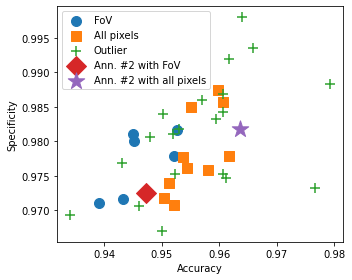

In [52]:
markers= ['o', 's', '+', 'x']

label_mapping= {'FoV': 'FoV', 'outlier': 'Outlier', 'no FoV': 'All pixels'}

plt.figure(figsize=(5, 4))
for i, c in enumerate(['FoV', 'no FoV', 'outlier']):
    plt.scatter(reduced[reduced['category'] == c]['acc'], reduced[reduced['category'] == c]['spec'], label=label_mapping[c], marker=markers[i], s=100)
plt.scatter([0.9473], [0.9725], label = 'Ann. #2 with FoV', marker='D', s=200)
plt.scatter([0.9636], [0.9818], label = 'Ann. #2 with all pixels', marker='*', s=300)
plt.xlabel('Accuracy')
plt.ylabel('Specificity')
#plt.gca().set_aspect(1.0)
plt.tight_layout()
plt.legend()
plt.savefig(os.path.join(figures_dir, 'image_level.pdf'))
plt.show()

In [53]:
methods= pd.merge(methods.reset_index(drop=True), reduced[['key', 'category']], on='key', how='left')

## Writing the results to file

In [54]:
methods.to_csv(image_level_results_file, index=False)

In [55]:
methods.columns

Index(['key', 'flag', 'year', 'all_previous_processed', 'acc', 'sens', 'spec', 'digits', 'highest_ranked', 'second_human_observer', 'second_human_acc', 'second_human_sens', 'second_human_spec', 'image_level', 'short_description', 'operating_principles', 'citations', 'explicit_fov_usage', 'invalid_ranking', 'cause_of_invalid_ranking', 'image_level_consistency_with_fov', 'image_level_consistency_without_fov', 'n_image_level', 'category'], dtype='object')

In [56]:
methods

,key,flag,year,all_previous_processed,acc,sens,spec,digits,highest_ranked,second_human_observer,...,short_description,operating_principles,citations,explicit_fov_usage,invalid_ranking,cause_of_invalid_ranking,image_level_consistency_with_fov,image_level_consistency_without_fov,n_image_level,category
0,adapa2020,primary,2020.0,yes,0.9450,0.6994,0.9811,4,thangaraj2017,no,...,neural network with Zernike moment features,"feature extraction, classification",4.0,no mention,yes,"fov, compares to thangaraj2017",1.00,0.000000,20.0,FoV
1,alom2019,primary,2019.0,yes,0.9613,0.7661,0.9807,4,alom2019,no,...,deep learning u-net,deep learning,46.0,no mention,yes,compares to azzopardi2014,NaN,NaN,NaN,NaN
2,anzalone2008,primary,2008.0,yes,0.9418,0.7286,0.9810,4,human,yes,...,"contrast enhancement, thresholding, cleaning","filtering, thresholding, morphology, region growing",57.0,yes,no,NaN,NaN,NaN,NaN,NaN
3,azzopardi2014,primary,2014.0,yes,0.9442,0.7655,0.9704,4,ricci2007,no,...,b-cosfire filter,"filtering, thresholding, morphology, region growing",445.0,no mention,yes,compares to ricci2007,NaN,NaN,NaN,NaN
4,barkana2017,primary,2017.0,yes,0.9502,0.7224,0.9840,4,wang2015,yes,...,feature extraction and classifier fusion,"feature extraction, classification",72.0,yes,yes,"compares mendonca2006, ricci2007",0.00,0.000000,4.0,outlier
5,brancati2018,primary,2018.0,yes,0.9490,0.7820,0.9760,3,frucci2017,yes,...,convolutional neural network,deep learning,0.0,yes,yes,compares frucci2017 to human_fov 0.947,NaN,NaN,NaN,NaN
6,budai2013,primary,2013.0,yes,0.9570,0.6440,0.9870,3,budai2013,yes,...,"multiscale filtering, postprocessing","filtering, thresholding, morphology, region growing",207.0,no mention,yes,compares to mendonca2006,NaN,NaN,NaN,NaN
7,chalakkal2017,primary,2017.0,yes,0.9518,0.7386,0.9769,4,lupascu2010,no,...,"filtering, fuzzy c-means, morphology","filtering, thresholding, morphology, region growing",12.0,no mention,yes,"compares to mendonca2006, lupascu2010",NaN,NaN,NaN,NaN
8,cheng2014,primary,2014.0,yes,0.9474,0.7252,0.9798,4,lupascu2010,yes,...,local feature extraction and pixelwise classification,"feature extraction, classification",80.0,no mention,yes,compares mendonca2006 to ricci2007 and lupascu2010,NaN,NaN,NaN,NaN
9,dai2015,primary,2015.0,yes,0.9418,0.7359,0.9720,4,dai2015,no,...,"Gabor-filter, classification, post-processing","filtering, thresholding, morphology, region growing",41.0,no mention,yes,"compares mendonca2006, ricci2007",NaN,NaN,NaN,NaN
